In [19]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set(style="darkgrid", palette="muted", font="serif")
plt.rcParams.update(plt.rcParamsDefault)

from abc import ABC, abstractmethod
import time
from typing import Callable, Tuple, List, Optional
import random
import itertools
from scipy.integrate import solve_ivp

from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *

plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

set_seed(42)

In [20]:
# generate trajectories for the target system
dt = 0.005
num_points = 10
dim = 3  # Three species
ml_system = MayLeonardSystem(dim=dim) 
lorenz_system = LorenzSystem(dim=dim, sigma=10, rho=313, beta=8/3.)   #gaiko2014global
noise_level = 0.
time_span = torch.tensor([0.0, .4])
init_points_bounds = [(44.7, 44.8), (80.7, 80.8), (352.3, 352.4)]  # 3D bounds
init_points_bounds = [(44, 45), (80, 81), (352, 353)]  # 3D bounds
#init_points_bounds = [(40, 50), (80, 90), (300, 400)]  # 3D bounds

t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method='uniform',         # Specifies the density-based sampling method
    init_points_bounds=init_points_bounds,                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=lorenz_system           # The target system, e.g., VanDerPol system
)

time_span = torch.tensor([0.0, .2])
initial_conditions = [trajectories_target[_, 8*_,:].clone().detach().numpy() for _ in range(num_points)] # Use the last point of the trajectory as the initial condition for the next trajectory
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    predefined_initial_conditions       =initial_conditions, # Predefined initial conditions for the target system
    time_span=time_span, # Time span for trajectory generation
    dt=dt, num_points=num_points,                     # Number of initial points to sample
    system=lorenz_system           # The target system, e.g., VanDerPol system
)

trajectories_target_centered = trajectories_target - trajectories_target.mean(dim=(0, 1), keepdim=True)
min_vals = trajectories_target_centered.amin(dim=(0, 1), keepdim=True)
max_vals = trajectories_target_centered.amax(dim=(0, 1), keepdim=True)

# Linearly scale to [-1, 1]
scaled = 2 * (trajectories_target_centered - min_vals) / (max_vals - min_vals) - 1
scaled_initial_conditions_target = scaled[:, 0, :]

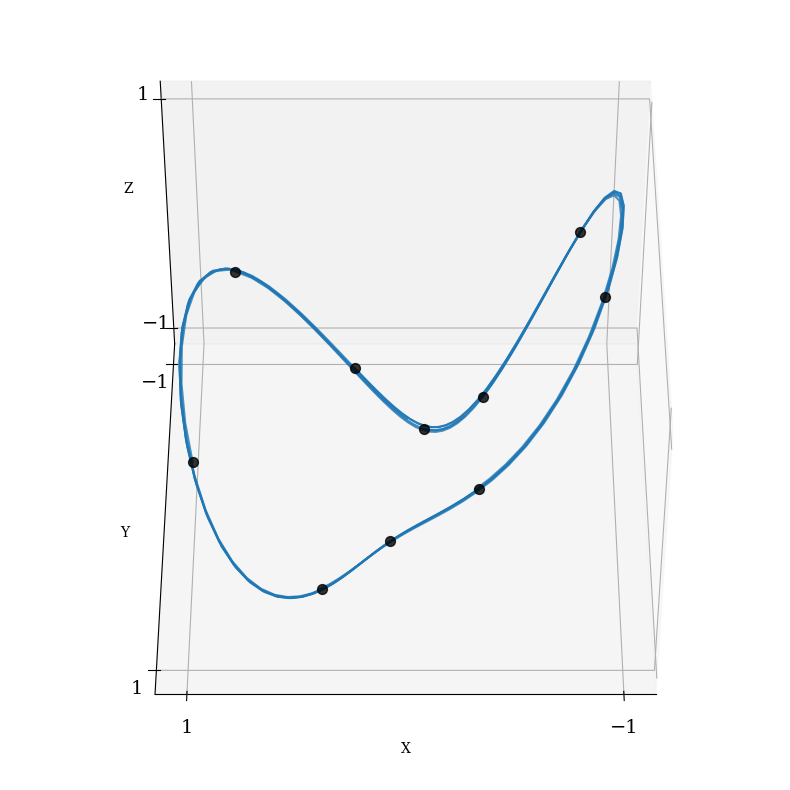

In [3]:
plot_trajectories_3d([scaled[:,:,:]], elev=45, azim=90)

In [4]:
limit_cycle_system = AnalyticalLimitCycle(dim=3, dt=dt, time_span=time_span, velocity_init=-1., alpha_init=-1)
motif_library = [limit_cycle_system]

num_epochs = 1000
layer_sizes= 2*[64]
lr = .01
annealing_params = {'initial_std': .0, 'final_std': 0., 'dynamic': False}

homeo_lc = NODEHomeomorphism(dim=dim, layer_sizes=layer_sizes)
homeo_networks = [homeo_lc] 
homeo_ds_networks = train_all_motifs(motif_library, homeo_networks, scaled, scaled_initial_conditions_target,
                                   lr=lr, num_epochs=num_epochs,
                                   annealing_params=annealing_params)

Training homeomorphism for motif: AnalyticalLimitCycle
Epoch 0, log(Loss)= -0.3661 Velocity:  -1.01
Epoch 10, log(Loss)= -0.7000 Velocity:  -1.041
Epoch 20, log(Loss)= -0.9012 Velocity:  -1.056
Epoch 30, log(Loss)= -1.1022 Velocity:  -1.08
Epoch 40, log(Loss)= -1.0763 Velocity:  -1.104
Epoch 50, log(Loss)= -1.2372 Velocity:  -1.142
Epoch 60, log(Loss)= -1.4397 Velocity:  -1.166
Epoch 70, log(Loss)= -1.3898 Velocity:  -1.186
Epoch 80, log(Loss)= -1.5095 Velocity:  -1.194
Epoch 90, log(Loss)= -1.7190 Velocity:  -1.204
Epoch 100, log(Loss)= -1.9500 Velocity:  -1.222
Epoch 110, log(Loss)= -1.3180 Velocity:  -1.24
Epoch 120, log(Loss)= -1.9498 Velocity:  -1.254
Epoch 130, log(Loss)= -2.0535 Velocity:  -1.273
Epoch 140, log(Loss)= -2.2443 Velocity:  -1.284
Epoch 150, log(Loss)= -2.1389 Velocity:  -1.297
Epoch 160, log(Loss)= -2.2544 Velocity:  -1.302
Epoch 170, log(Loss)= -2.3515 Velocity:  -1.31
Epoch 180, log(Loss)= -2.6536 Velocity:  -1.32
Epoch 190, log(Loss)= -3.0746 Velocity:  -1.331
E

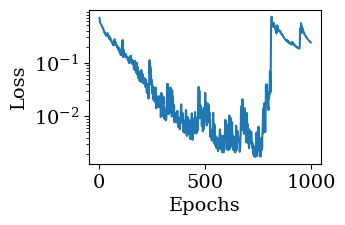

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(homeo_lc.losses)
ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.show()

In [98]:
trajectories_source_list, transformed_trajectories_list, error = test_homeo_networks(scaled, homeo_ds_networks, plot_first_n = 10, time_span=np.array([0.0, 1.0]))
transformed_trajectories = transformed_trajectories_list[0]
trajectories_centered = ((transformed_trajectories + 1) / 2) * (max_vals.detach().numpy() - min_vals.detach().numpy()) + min_vals.detach().numpy()
transformed_trajectories_list[0] = trajectories_centered

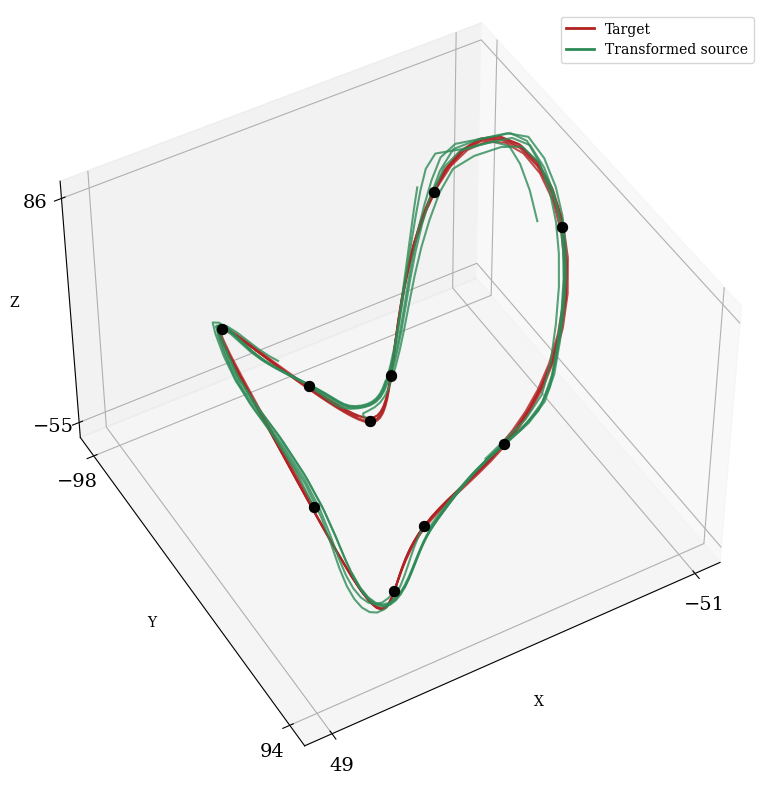

In [114]:
plot_trajectories_3d([trajectories_target_centered.detach().numpy(), transformed_trajectories_list[0][:,:,:]],
                     labels=['Target', 'Transformed source'],
                     colors=['firebrick', 'seagreen'],
                     save_name='lorenz_node_analytical.pdf',
                       elev=45, azim=60)

In [ ]:
#save_homeo_ds_net(homeo_ds_networks[0], "model_lorenz_analytical.pth")


Model saved to model_lorenz_analytical.pth
